# Baseline: ResNet50

In [ ]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If you’re using multi-GPU
np.random.seed(seed)
random.seed(seed)

# For CuDNN (explained below)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from glob import glob
from PIL import Image
import os

## Set Dataset Paths
dataset_path = '/content/drive/MyDrive/CS 230 Project/data/archive'
train_images_dir = os.path.join(dataset_path, 'train/images')
train_labels_dir = os.path.join(dataset_path, 'train/labels')
valid_images_dir = os.path.join(dataset_path, 'valid/images')
valid_labels_dir = os.path.join(dataset_path, 'valid/labels')


# Check if the base path exists
base_path = '/content/drive/MyDrive/CS 230 Project/data/archive'
print(f"Base path exists: {os.path.exists(base_path)}")

# Check if the train/images directory exists
train_images_dir = os.path.join(base_path, 'train/images')
print(f"Train images path exists: {os.path.exists(train_images_dir)}")

# Check if the train/labels directory exists
train_labels_dir = os.path.join(base_path, 'train/labels')
print(f"Train labels path exists: {os.path.exists(train_labels_dir)}")

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, predictions, targets):
        """
        predictions: Raw logits output by the model (shape: [batch_size, 7])
        targets: Ground truth labels (shape: [batch_size, 7])
        """
        # Compute standard BCE loss
        bce_loss = self.bce_loss(predictions, targets)

        # Apply the "Healthy" constraint
        healthy_idx = 2  # "Healthy" is the 3rd class (index 2)
        healthy_mask = targets[:, healthy_idx] == 1  # Identify healthy samples

        # If healthy, all other predictions should be close to 0
        if healthy_mask.any():
            non_healthy_preds = predictions[healthy_mask][:, [i for i in range(7) if i != healthy_idx]]
            penalty = torch.sigmoid(non_healthy_preds).mean()  # Penalize non-zero predictions
            return bce_loss + 0.1*penalty

        return bce_loss

## Custom Dataset Class
class TomatoDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, num_classes=7):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = sorted(glob(os.path.join(images_dir, "*.jpg")))  # Adjust extension if needed
        self.label_files = sorted(glob(os.path.join(labels_dir, "*.txt")))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Load and process label
        label_path = self.label_files[idx]
        label = self.parse_label_file(label_path)

        return image, label

    def parse_label_file(self, label_file):
        labels = np.zeros(self.num_classes, dtype=np.float32)  # Assuming one label per image
        with open(label_file, 'r') as f:
            for line in f:
                cls_id, _, _, _, _ = map(float, line.strip().split())
                labels[int(cls_id)] = 1  # One-hot encode the class
        return torch.tensor(labels)


########################## Include either the complex or simple data augmentation #############
# # Data Transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

## Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

##############################################################################################

## Create Datasets and Dataloaders
train_dataset = TomatoDataset(train_images_dir, train_labels_dir, transform, num_classes=7)
valid_dataset = TomatoDataset(valid_images_dir, valid_labels_dir, transform, num_classes=7)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

## Load Pretrained ResNet50 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Modify the final layer for our number of classes
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 7)  # Number of classes
)

model = model.to(device)

## Define Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Use BCE with logits for multi-label classification

# Replace the criterion with the custom loss function
# criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Base path exists: True
Train images path exists: True
Train labels path exists: True


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.4813, Valid Loss: 0.3276
Epoch [2/10], Train Loss: 0.2726, Valid Loss: 0.2236
Epoch [3/10], Train Loss: 0.1917, Valid Loss: 0.1748
Epoch [4/10], Train Loss: 0.1485, Valid Loss: 0.1421
Epoch [5/10], Train Loss: 0.1260, Valid Loss: 0.1244
Epoch [6/10], Train Loss: 0.1038, Valid Loss: 0.1012
Epoch [7/10], Train Loss: 0.0942, Valid Loss: 0.0981
Epoch [8/10], Train Loss: 0.0845, Valid Loss: 0.0861
Epoch [9/10], Train Loss: 0.0804, Valid Loss: 0.0943


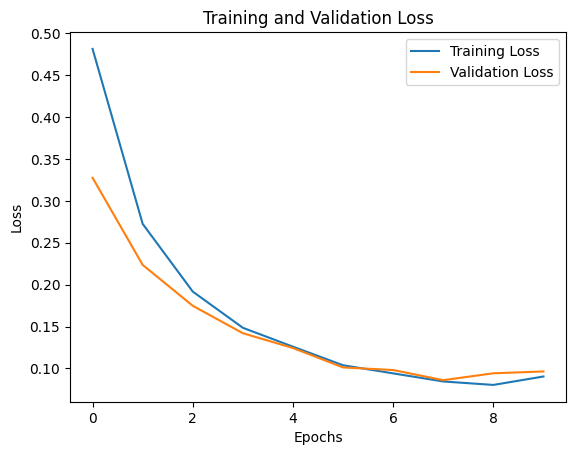

Class 0 - Precision: 1.0000, Recall: 0.3333, F1-Score: 0.5000
Class 1 - Precision: 0.9688, Recall: 1.0000, F1-Score: 0.9841
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
Class 3 - Precision: 1.0000, Recall: 0.9231, F1-Score: 0.9600
Class 4 - Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
Class 5 - Precision: 0.6000, Recall: 0.6000, F1-Score: 0.6000
Class 6 - Precision: 0.9474, Recall: 0.8571, F1-Score: 0.9000

Overall Metrics:
Accuracy (Subset Accuracy): 0.8689
Overall Precision (Macro Average): 0.9309
Overall Recall (Macro Average): 0.8162
Overall F1-Score (Macro Average): 0.8492
Hamming Loss: 0.0281
Hamming Score: 0.9719


In [ ]:
import numpy as np
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, hamming_loss

# Training loop
EPOCHS = 10
train_losses = []
valid_losses = []

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    return train_loss / len(train_loader.dataset)

def valid_epoch(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
    return valid_loss / len(valid_loader.dataset)

# Training and validation loop
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    valid_loss = valid_epoch(model, valid_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

# Plot loss curves
import matplotlib.pyplot as plt
plt.plot(range(EPOCHS), train_losses, label='Training Loss')
plt.plot(range(EPOCHS), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate metrics (accuracy, precision, recall, F1-score, Hamming loss, and subset accuracy)
def evaluate_metrics(model, valid_loader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Binarize predictions
            true_labels.append(labels.cpu().numpy())
            pred_labels.append(preds.cpu().numpy())

    true_labels = np.concatenate(true_labels, axis=0)
    pred_labels = np.concatenate(pred_labels, axis=0)

    # Calculate precision, recall, and F1-score for each label
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average=None)

    # Calculate overall accuracy (Subset Accuracy / Exact Match Ratio)
    accuracy = accuracy_score(true_labels, pred_labels)

    # Calculate Hamming Loss
    hamming = hamming_loss(true_labels, pred_labels)

    # Calculate Hamming Score (1 - Hamming Loss)
    hamming_score = 1 - hamming

    # Print results for each class
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        print(f"Class {i} - Precision: {p:.4f}, Recall: {r:.4f}, F1-Score: {f:.4f}")

    # Print overall metrics
    print(f"\nOverall Metrics:")
    print(f"Accuracy (Subset Accuracy): {accuracy:.4f}")
    print(f"Overall Precision (Macro Average): {np.mean(precision):.4f}")
    print(f"Overall Recall (Macro Average): {np.mean(recall):.4f}")
    print(f"Overall F1-Score (Macro Average): {np.mean(f1):.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"Hamming Score: {hamming_score:.4f}")

    return precision, recall, f1, accuracy, hamming_loss, hamming_score

# Call the function to evaluate metrics
precision, recall, f1, accuracy, hamming_loss_value, hamming_score = evaluate_metrics(model, valid_loader)

Raw output: tensor([[ -7.5732,   7.9718, -16.8264,  -3.3489,  -4.9250,  -9.6797,   6.6998]],
       device='cuda:0')
Predicted probabilities (after sigmoid): [5.1377085e-04 9.9965501e-01 4.9247255e-08 3.3932675e-02 7.2101941e-03
 6.2535757e-05 9.9877042e-01]
Predicted labels (after thresholding): [False  True False False False False  True]


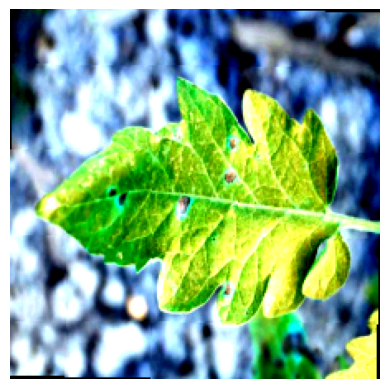

True Labels:
[1, 6]

Predicted Labels:
[1, 6]


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

def visualize_random_prediction(model, train_loader):
    # Set the model to evaluation mode
    model.eval()

    # Get a random image from the training set
    random_idx = random.randint(0, len(train_loader.dataset) - 1)
    image, true_label = train_loader.dataset[random_idx]

    # Add batch dimension and move image to the device
    image = image.unsqueeze(0).to(device)
    true_label = true_label.to(device)

    # Perform a forward pass through the model
    with torch.no_grad():
        output = model(image)

    # Debugging: Print the raw output values (logits or probabilities)
    print(f"Raw output: {output}")

    # Get predictions (for multi-label, sigmoid and threshold at 0.5)
    pred_label = torch.sigmoid(output).squeeze().cpu().numpy()
    print(f"Predicted probabilities (after sigmoid): {pred_label}")

    # Threshold at 0.5 for multi-label classification
    pred_label = pred_label > 0.5

    # Debugging: Print the thresholded predictions
    print(f"Predicted labels (after thresholding): {pred_label}")

    # Convert the image back to numpy for visualization
    img = image.squeeze().cpu().permute(1, 2, 0).numpy()
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    # Convert the image to RGB for displaying in matplotlib (OpenCV uses BGR by default)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Display the image
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

    # Print the true and predicted labels
    print("True Labels:")
    true_labels = [i for i, val in enumerate(true_label.cpu().numpy()) if val == 1]
    print(true_labels)

    print("\nPredicted Labels:")
    predicted_labels = [i for i, val in enumerate(pred_label) if val == 1]
    print(predicted_labels)

visualize_random_prediction(model, valid_loader)

# Try to improve the resnet50 model with a Squeeze and Excitation (SE) layer.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Base Model 1...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 0.4970 | Valid Loss: 0.3284
    Precision: 0.8214 | Recall: 0.4792 | F1: 0.6053 | Accuracy: 0.7377
    Hamming Loss: 0.1405 | Hamming Score: 0.8595 | Subset Accuracy: 0.3934
Epoch 2/10 | Train Loss: 0.3059 | Valid Loss: 0.2259
    Precision: 0.9167 | Recall: 0.6875 | F1: 0.7857 | Accuracy: 0.8033
    Hamming Loss: 0.0843 | Hamming Score: 0.9157 | Subset Accuracy: 0.5738
Epoch 3/10 | Train Loss: 0.2356 | Valid Loss: 0.1796
    Precision: 0.9351 | Recall: 0.7500 | F1: 0.8324 | Accuracy: 0.8852
    Hamming Loss: 0.0679 | Hamming Score: 0.9321 | Subset Accuracy: 0.6393
Epoch 4/10 | Train Loss: 0.1790 | Valid Loss: 0.1397
    Precision: 0.9302 | Recall: 0.8333 | F1: 0.8791 | Accuracy: 0.9016
    Hamming Loss: 0.0515 | Hamming Score: 0.9485 | Subset Accuracy: 0.7377
Epoch 5/10 | Train Loss: 0.1759 | Valid Loss: 0.1594
    Precision: 0.9277 | Recall: 0.8021 | F1: 0.8603 | Accuracy: 0.9180
    Hamming Loss: 0.0585 | Hamming Score: 0.9415 | Subset Accuracy: 0.6885
Epoch

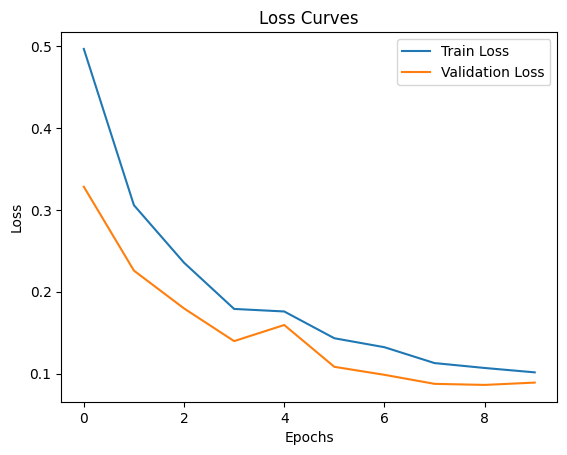

In [ ]:
# Imports
from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torchvision.models import efficientnet_b0
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Dataset Paths
dataset_path = '/content/drive/MyDrive/CS 230 Project/data/archive'
train_images_dir = os.path.join(dataset_path, 'train/images')
train_labels_dir = os.path.join(dataset_path, 'train/labels')
valid_images_dir = os.path.join(dataset_path, 'valid/images')
valid_labels_dir = os.path.join(dataset_path, 'valid/labels')

# Custom Dataset Class
class TomatoDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, num_classes=7):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = sorted(glob(os.path.join(images_dir, "*.jpg")))  # Adjust extension if needed
        self.label_files = sorted(glob(os.path.join(labels_dir, "*.txt")))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label_path = self.label_files[idx]
        label = self.parse_label_file(label_path)
        return image, label

    def parse_label_file(self, label_file):
        labels = np.zeros(self.num_classes, dtype=np.float32)
        with open(label_file, 'r') as f:
            for line in f:
                cls_id, _, _, _, _ = map(float, line.strip().split())
                labels[int(cls_id)] = 1
        return torch.tensor(labels)

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and Dataloaders
train_dataset = TomatoDataset(train_images_dir, train_labels_dir, transform, num_classes=7)
valid_dataset = TomatoDataset(valid_images_dir, valid_labels_dir, transform, num_classes=7)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

class EarlyStopping:
    def __init__(self, patience=3, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

# Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = torch.mean(x, dim=(2, 3))  # Global Average Pooling
        y = torch.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        y = y.view(batch, channels, 1, 1)
        return x * y

# Modify ResNet50 with SE Block
class ResNet50WithSE(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50WithSE, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.se_block = SEBlock(self.base_model.layer4[-1].conv3.out_channels)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)
        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)
        x = self.se_block(x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.fc(x)
        return x

# Modify EfficientNet with SE Block (Optional)
class EfficientNetWithSE(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetWithSE, self).__init__()
        self.base_model = efficientnet_b0(pretrained=True)
        self.se_block = SEBlock(self.base_model.features[-1][0].out_channels)
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.se_block(x)  # Apply SE block
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.classifier(x)
        return x

# Initialize Base Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model_1 = ResNet50WithSE(num_classes=7).to(device)

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, predictions, targets):
        """
        predictions: Raw logits output by the model (shape: [batch_size, 7])
        targets: Ground truth labels (shape: [batch_size, 7])
        """
        # Compute standard BCE loss
        bce_loss = self.bce_loss(predictions, targets)

        # Apply the "Healthy" constraint
        healthy_idx = 2  # "Healthy" is the 3rd class (index 2)
        healthy_mask = targets[:, healthy_idx] == 1  # Identify healthy samples

        # If healthy, all other predictions should be close to 0
        if healthy_mask.any():
            non_healthy_preds = predictions[healthy_mask][:, [i for i in range(7) if i != healthy_idx]]
            penalty = torch.sigmoid(non_healthy_preds).mean()  # Penalize non-zero predictions
            return bce_loss + 2*penalty

        return bce_loss

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
# criterion = CustomLoss()
optimizer_1 = optim.Adam(base_model_1.parameters(), lr=0.0001, weight_decay=1e-4)

# Train Function
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(data_loader.dataset)

# Validation Function
def validate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return running_loss / len(data_loader.dataset), all_preds, all_labels

early_stopping = EarlyStopping(patience=3, delta=0.01)

# Train Base Model Function
def train_base_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10):
    train_losses, valid_losses = [], []
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
    for epoch in range(epochs):
        # Train the model for one epoch
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        valid_loss, preds, labels = validate(model, valid_loader, criterion)

        # Adjust learning rate based on validation loss
        scheduler.step(valid_loss)

        # Early stopping condition
        early_stopping(valid_loss)
        if early_stopping.stop:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        # Save loss values
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Binarize predictions
        preds = (preds > 0.5).float()

        # Calculate precision, recall, F1-score, accuracy, and other metrics
        precision, recall, f1, _ = precision_recall_fscore_support(labels.numpy(), preds.numpy(), average='micro')
        accuracy = accuracy_score(labels.numpy().argmax(axis=1), preds.numpy().argmax(axis=1))

        # Hamming Loss and Hamming Score
        hamming_loss = np.mean(np.not_equal(labels.numpy(), preds.numpy()))
        hamming_score = 1 - hamming_loss  # Hamming score is complement of Hamming loss

        # Subset Accuracy / Exact Match Ratio
        subset_accuracy = np.mean(np.all(labels.numpy() == preds.numpy(), axis=1))

        # Print metrics for the epoch
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")
        print(f"    Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Accuracy: {accuracy:.4f}")
        print(f"    Hamming Loss: {hamming_loss:.4f} | Hamming Score: {hamming_score:.4f} | Subset Accuracy: {subset_accuracy:.4f}")

    return train_losses, valid_losses

# Train Base Models
print("Training Base Model 1...")
train_losses_1, valid_losses_1 = train_base_model(base_model_1, train_loader, valid_loader, criterion, optimizer_1)

# Loss Plot
def plot_losses(train_losses, valid_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

# Plotting Loss Curves
print("Loss Curves for Base Model 1")
plot_losses(train_losses_1, valid_losses_1)

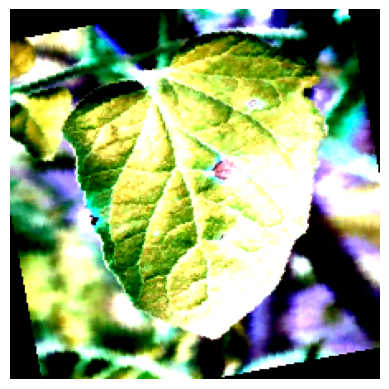

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0298_JPG.rf.084b8d28ed173d8b73f2218748798a30.jpg
True Labels:
[1, 3, 6]

Predicted Labels:
[0, 2, 4]


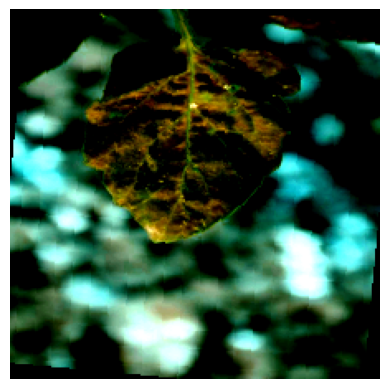

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0352_JPG.rf.97d9f7cc98eb9a23489b2a7cc0ce21cb.jpg
True Labels:
[1, 6]

Predicted Labels:
[0, 2, 4, 5]


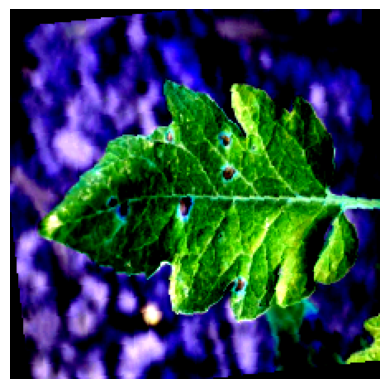

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0267_JPG.rf.9bd28206beaf649d2d90b75c4a63925d.jpg
True Labels:
[1, 6]

Predicted Labels:
[0, 2, 4, 5]


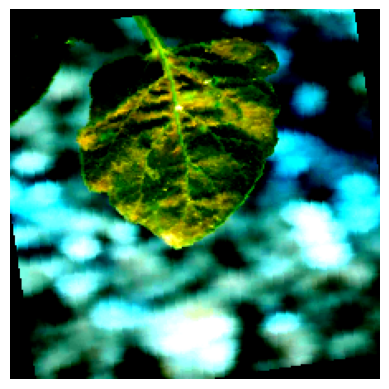

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0353_JPG.rf.b28675e805a145d1fa309c5204a9ca32.jpg
True Labels:
[1, 6]

Predicted Labels:
[0, 2, 4, 5]


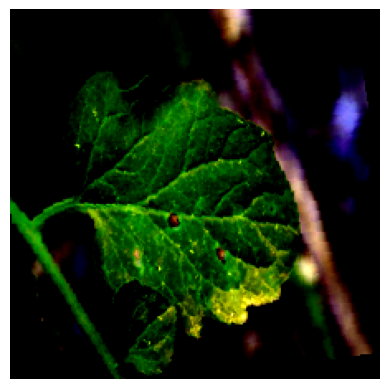

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0374_JPG.rf.d8500567e50eea6cf2959891f12af373.jpg
True Labels:
[0, 1]

Predicted Labels:
[0, 2, 4]


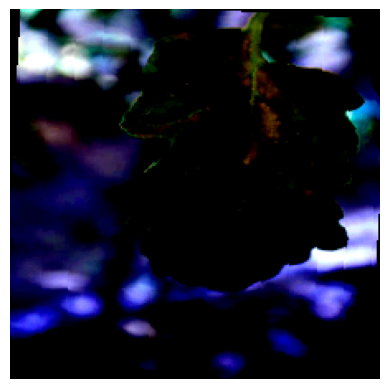

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0348_JPG.rf.224036500acd87dc9766c6be084e67a5.jpg
True Labels:
[0, 3]

Predicted Labels:
[0, 4, 5]


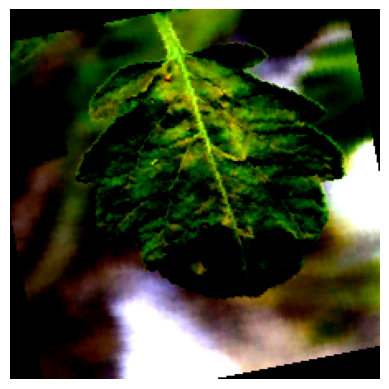

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0215_JPG.rf.72f64552ad2cd18b9534adce25f54cc5.jpg
True Labels:
[]

Predicted Labels:
[0, 2, 4]


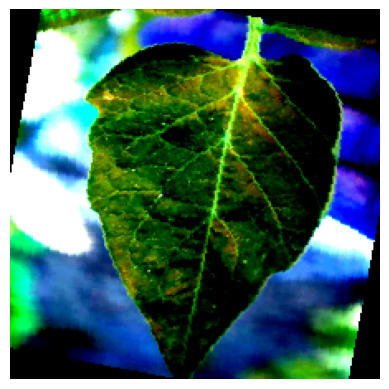

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0339_JPG.rf.9f1dbac6210f077f2b3d89b05d09afbd.jpg
True Labels:
[2]

Predicted Labels:
[0, 2, 4]


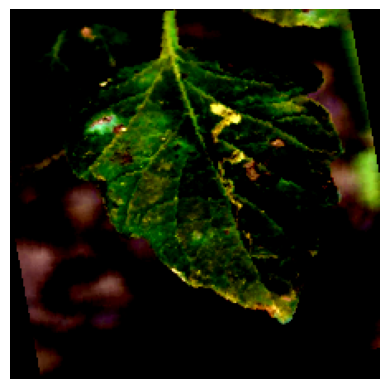

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0364_JPG.rf.969269cf51f71efda5d59828d716f7b1.jpg
True Labels:
[1, 5, 6]

Predicted Labels:
[0, 2, 4]


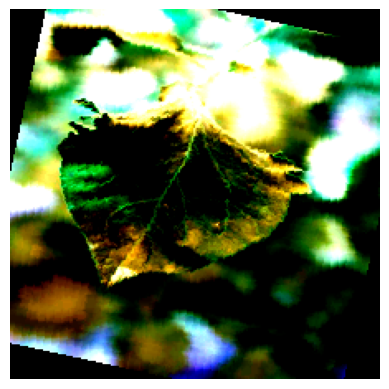

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0236_JPG.rf.36a3106474d9b044d52908f150163db2.jpg
True Labels:
[2]

Predicted Labels:
[0, 1, 2, 4]


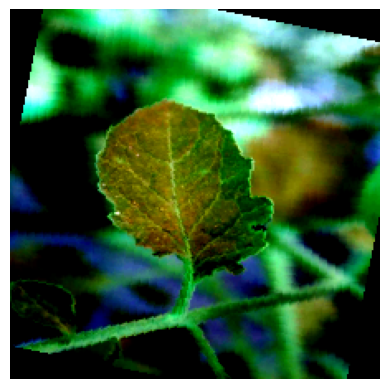

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0328_JPG.rf.c49cbf8582f2bd4309822c7c8e8a04c2.jpg
True Labels:
[3]

Predicted Labels:
[0, 2]


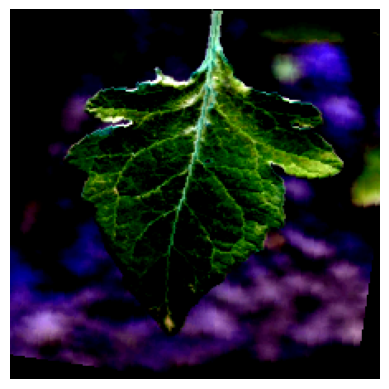

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0265_JPG.rf.72c7a148143a2bead15625112da81eb6.jpg
True Labels:
[2]

Predicted Labels:
[0, 2, 4]


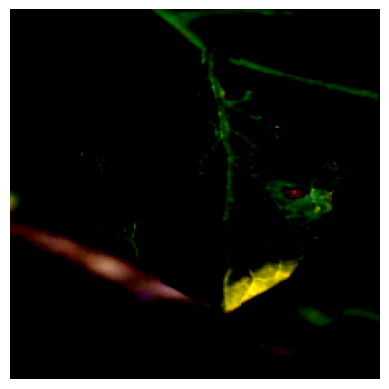

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0369_JPG.rf.a2f219937fcefabd19611c93f0885a96.jpg
True Labels:
[1, 5]

Predicted Labels:
[0, 2, 4, 5]


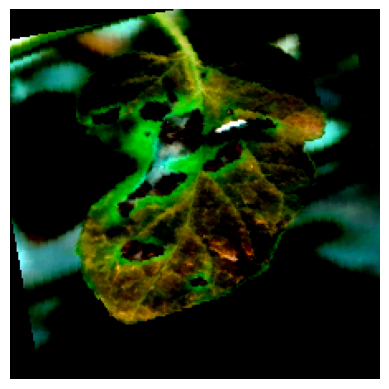

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0316_JPG.rf.8c53c509c26cc8f2c2339297d0e4eb8f.jpg
True Labels:
[1, 3]

Predicted Labels:
[0, 2, 4]


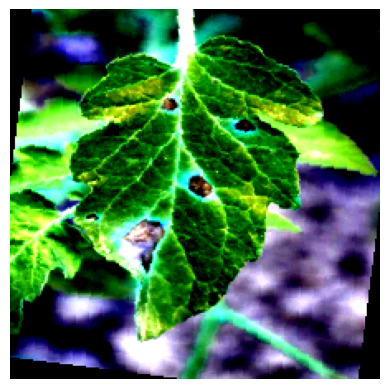

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0295_JPG.rf.a5becd6823dd2a978b25598cc49b3e99.jpg
True Labels:
[1, 3, 6]

Predicted Labels:
[0, 2, 4]


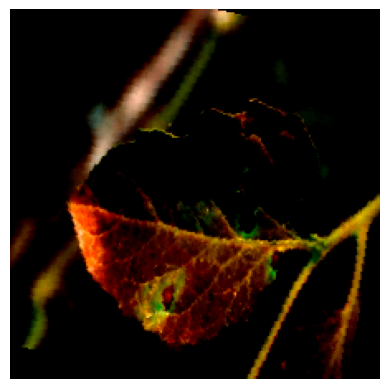

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0373_JPG.rf.c265dc0679fe74ab8365de813413405d.jpg
True Labels:
[1]

Predicted Labels:
[0, 2, 4, 5]


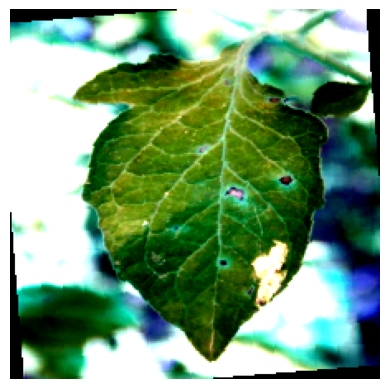

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0355_JPG.rf.16326195e6c5e631cc0049401720a19d.jpg
True Labels:
[1, 3, 6]

Predicted Labels:
[0, 2, 4]


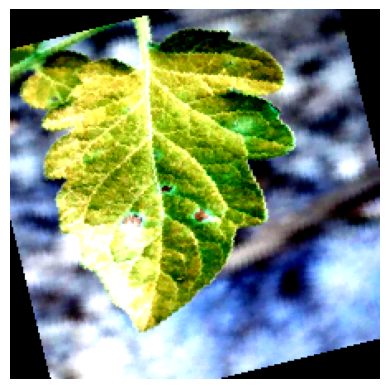

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0272_JPG.rf.09589608e4153af9abd9d62ebc699e3f.jpg
True Labels:
[1, 4, 6]

Predicted Labels:
[0, 2, 4]


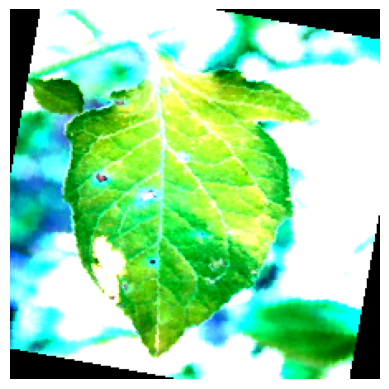

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0357_JPG.rf.cc49f91ca5b270e5dad572683d6b1905.jpg
True Labels:
[1, 3, 6]

Predicted Labels:
[0, 2, 4]


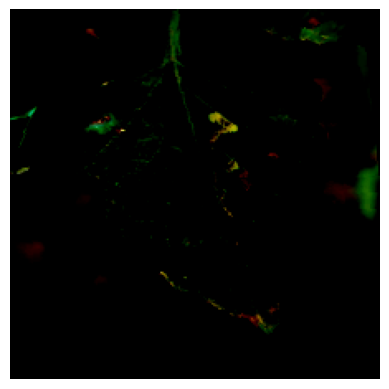

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0366_JPG.rf.4aef33c7c8c8f5a462d6b4bfb2354b9e.jpg
True Labels:
[1, 6]

Predicted Labels:
[0, 2, 4, 5]


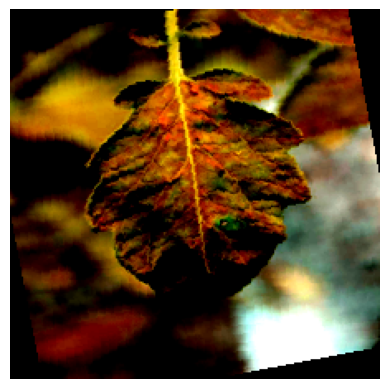

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0210_JPG.rf.88fef2f797fa888a725ec075a039aa57.jpg
True Labels:
[]

Predicted Labels:
[0, 1, 2, 4, 5]


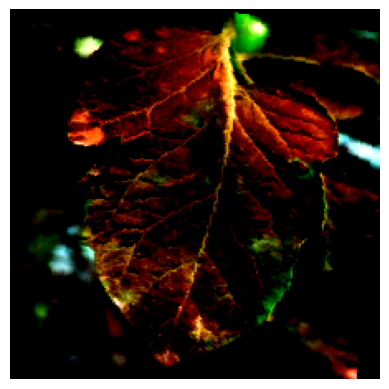

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0230_JPG.rf.6aa737da228dfd6ab26b74bbcd84b98e.jpg
True Labels:
[1, 4, 6]

Predicted Labels:
[0, 2, 4]


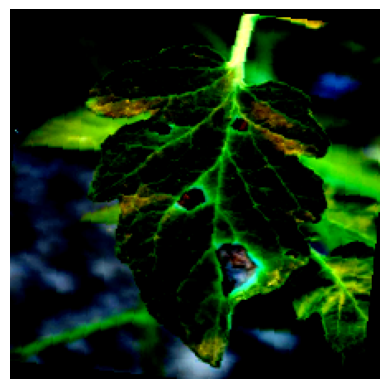

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0292_JPG.rf.d355877b47f619f7e7239e90212a6210.jpg
True Labels:
[1, 3, 6]

Predicted Labels:
[0, 2, 4]


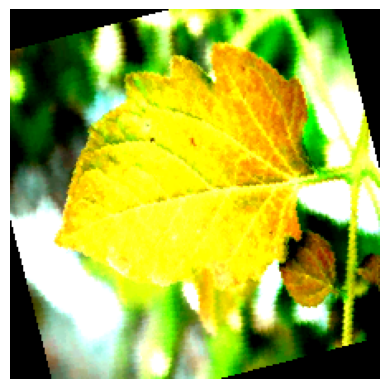

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0480_JPG.rf.0d7f67e61c9b960f384c12d689606789.jpg
True Labels:
[2]

Predicted Labels:
[0, 1, 2, 4]


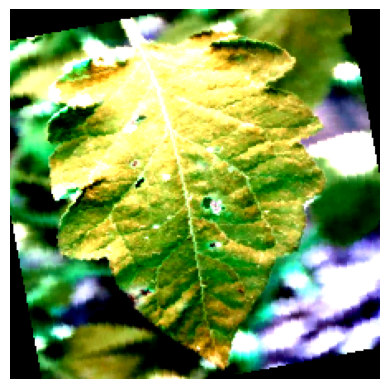

Filename: /content/drive/MyDrive/CS 230 Project/data/archive/valid/images/IMG_0255_JPG.rf.140cd477c07a7f6fcdb21209f97cf11c.jpg
True Labels:
[1, 4, 6]

Predicted Labels:
[0, 2, 4]


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

def visualize_bad_examples_with_filenames(model, data_loader, dataset, num_examples=5):
    """
    Visualizes misclassified examples from the dataset and prints their filenames.

    Args:
        model: The trained model.
        data_loader: DataLoader object for validation or test data.
        dataset: The dataset object corresponding to the data_loader.
        num_examples: Number of bad examples to visualize.
    """
    # Set the model to evaluation mode
    model.eval()

    # Container to hold bad examples
    bad_examples = []

    # Iterate through the data loader to find misclassified examples
    for idx, (images, true_labels) in enumerate(data_loader):
        # Move data to the device
        images = images.to(device)
        true_labels = true_labels.to(device)

        # Perform a forward pass through the model
        with torch.no_grad():
            outputs = model(images)

        # Get predictions (apply sigmoid and threshold at 0.5)
        pred_labels = torch.sigmoid(outputs) > 0.5

        # Identify misclassified samples
        for i in range(images.size(0)):
            if not torch.equal(pred_labels[i], true_labels[i]):
                # Retrieve the filename from the dataset
                filename = dataset.image_files[idx * data_loader.batch_size + i]
                bad_examples.append((images[i], true_labels[i], pred_labels[i], filename))

        # Stop if we've collected enough bad examples
        if len(bad_examples) >= num_examples:
            break

    # Randomly sample `num_examples` from bad_examples
    bad_examples = random.sample(bad_examples, min(len(bad_examples), num_examples))

    # Visualize bad examples
    for img, true_label, pred_label, filename in bad_examples:
        # Convert the image back to numpy for visualization
        img = img.cpu().permute(1, 2, 0).numpy()  # Convert to HWC format
        img = np.clip(img * 255, 0, 255).astype(np.uint8)  # Rescale pixel values

        # Convert the image to RGB for displaying in matplotlib (OpenCV uses BGR by default)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # Display the image
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

        # Print the filename, true labels, and predicted labels
        print(f"Filename: {filename}")
        print("True Labels:")
        true_labels = [i for i, val in enumerate(true_label.cpu().numpy()) if val == 1]
        print(true_labels)

        print("\nPredicted Labels:")
        predicted_labels = [i for i, val in enumerate(pred_label.cpu().numpy()) if val == 1]
        print(predicted_labels)

# Call the function with your validation loader and dataset
visualize_bad_examples_with_filenames(model, valid_loader, valid_dataset, num_examples=25)


In [ ]:
def count_missing_labels(dataset):
    """
    Count the number of files in the dataset that don't have labels.

    Args:
        dataset: An instance of TomatoDataset.

    Returns:
        missing_count: Number of images without valid labels.
        missing_files: List of filenames with missing labels.
    """
    missing_count = 0
    missing_files = []

    for idx in range(len(dataset)):
        img_path = dataset.image_files[idx]
        label_path = dataset.label_files[idx]

        # Try to read the label
        try:
            label = dataset.parse_label_file(label_path)
            # Check if all labels are zeros (no classes assigned)
            if torch.sum(label) == 0:
                missing_count += 1
                missing_files.append(img_path)
        except Exception as e:
            # Handle cases where the label file is missing or invalid
            missing_count += 1
            missing_files.append(img_path)
            print(f"Error processing {label_path}: {e}")

    return missing_count, missing_files

# Example usage
missing_count, missing_files = count_missing_labels(train_dataset)
print(f"Number of files without valid labels: {missing_count}")
print("Files with missing labels:")
for file in missing_files:
    print(file)


Number of files without valid labels: 18
Files with missing labels:
/content/drive/MyDrive/CS 230 Project/data/archive/train/images/IMG_0213_JPG.rf.39d1e47fe401ff4f0ed7becec0fc997c.jpg
/content/drive/MyDrive/CS 230 Project/data/archive/train/images/IMG_0213_JPG.rf.6ae88337d39608b8566aa7a0a3c042df.jpg
/content/drive/MyDrive/CS 230 Project/data/archive/train/images/IMG_0213_JPG.rf.c3d06634ba033bc2aa45b4196177733f.jpg
/content/drive/MyDrive/CS 230 Project/data/archive/train/images/IMG_0214_JPG.rf.256ab89188a6a009f654161bcc04fc64.jpg
/content/drive/MyDrive/CS 230 Project/data/archive/train/images/IMG_0214_JPG.rf.4ed66c48b590e58096cb5bdd7007ef31.jpg
/content/drive/MyDrive/CS 230 Project/data/archive/train/images/IMG_0214_JPG.rf.ff901d83bb7227dd3800eed1eb0aa6dc.jpg
/content/drive/MyDrive/CS 230 Project/data/archive/train/images/IMG_0330_JPG.rf.745cebf4e282b04cb36dd50cdad81f94.jpg
/content/drive/MyDrive/CS 230 Project/data/archive/train/images/IMG_0330_JPG.rf.820e5767005a8cf928a9e0680f2bb211.

# Approach: Implement EfficientNet and enhance with Squeeze-and-Excitation layer

Training Base Model 1...
Training Base Model 2...
Epoch 1/10 | Train Loss: 0.6157 | Valid Loss: 0.4848
    Precision: 0.6122 | Recall: 0.3125 | F1: 0.4138 | Accuracy: 0.4918
    Hamming Loss: 0.1991 | Hamming Score: 0.8009 | Subset Accuracy: 0.1148
Epoch 2/10 | Train Loss: 0.4159 | Valid Loss: 0.3765
    Precision: 0.7708 | Recall: 0.3854 | F1: 0.5139 | Accuracy: 0.5902
    Hamming Loss: 0.1639 | Hamming Score: 0.8361 | Subset Accuracy: 0.2295
Epoch 3/10 | Train Loss: 0.3064 | Valid Loss: 0.2559
    Precision: 0.9000 | Recall: 0.6562 | F1: 0.7590 | Accuracy: 0.7541
    Hamming Loss: 0.0937 | Hamming Score: 0.9063 | Subset Accuracy: 0.5246
Epoch 4/10 | Train Loss: 0.2263 | Valid Loss: 0.1958
    Precision: 0.9405 | Recall: 0.8229 | F1: 0.8778 | Accuracy: 0.8525
    Hamming Loss: 0.0515 | Hamming Score: 0.9485 | Subset Accuracy: 0.6885
Epoch 5/10 | Train Loss: 0.1783 | Valid Loss: 0.1499
    Precision: 0.9535 | Recall: 0.8542 | F1: 0.9011 | Accuracy: 0.9180
    Hamming Loss: 0.0422 | Ham

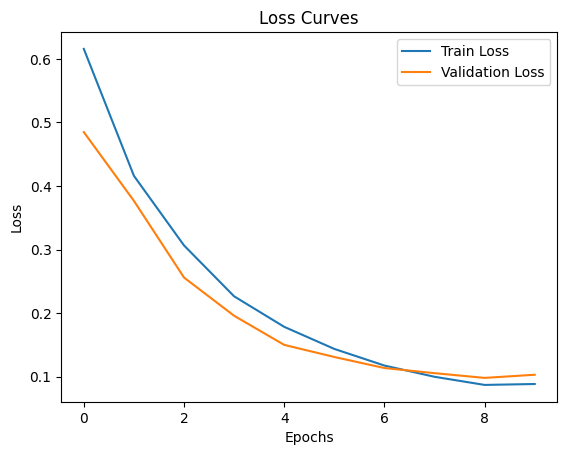

In [ ]:
# Imports
from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torchvision.models import efficientnet_b0
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Dataset Paths
dataset_path = '/content/drive/MyDrive/CS 230 Project/data/archive'
train_images_dir = os.path.join(dataset_path, 'train/images')
train_labels_dir = os.path.join(dataset_path, 'train/labels')
valid_images_dir = os.path.join(dataset_path, 'valid/images')
valid_labels_dir = os.path.join(dataset_path, 'valid/labels')

# Custom Dataset Class
class TomatoDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, num_classes=7):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = sorted(glob(os.path.join(images_dir, "*.jpg")))  # Adjust extension if needed
        self.label_files = sorted(glob(os.path.join(labels_dir, "*.txt")))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label_path = self.label_files[idx]
        label = self.parse_label_file(label_path)
        return image, label

    def parse_label_file(self, label_file):
        labels = np.zeros(self.num_classes, dtype=np.float32)
        with open(label_file, 'r') as f:
            for line in f:
                cls_id, _, _, _, _ = map(float, line.strip().split())
                labels[int(cls_id)] = 1
        return torch.tensor(labels)

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets and Dataloaders
train_dataset = TomatoDataset(train_images_dir, train_labels_dir, transform, num_classes=7)
valid_dataset = TomatoDataset(valid_images_dir, valid_labels_dir, transform, num_classes=7)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

class EarlyStopping:
    def __init__(self, patience=3, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

# Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = torch.mean(x, dim=(2, 3))  # Global Average Pooling
        y = torch.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        y = y.view(batch, channels, 1, 1)
        return x * y

# Modify ResNet50 with SE Block
class ResNet50WithSE(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50WithSE, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.se_block = SEBlock(self.base_model.layer4[-1].conv3.out_channels)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)
        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)
        x = self.se_block(x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.fc(x)
        return x

# Modify EfficientNet with SE Block (Optional)
class EfficientNetWithSE(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetWithSE, self).__init__()
        self.base_model = efficientnet_b0(pretrained=True)
        self.se_block = SEBlock(self.base_model.features[-1][0].out_channels)
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.se_block(x)  # Apply SE block
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.classifier(x)
        return x

# Initialize Base Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model_1 = ResNet50WithSE(num_classes=7).to(device)
base_model_2 = EfficientNetWithSE(num_classes=7).to(device)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer_1 = optim.Adam(base_model_1.parameters(), lr=0.0001, weight_decay=1e-4)
optimizer_2 = optim.Adam(base_model_2.parameters(), lr=0.0001, weight_decay=1e-4)

# Train Function
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(data_loader.dataset)

# Validation Function
def validate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return running_loss / len(data_loader.dataset), all_preds, all_labels

early_stopping = EarlyStopping(patience=3, delta=0.01)

# Train Base Model Function
def train_base_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10):
    train_losses, valid_losses = [], []
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
    for epoch in range(epochs):
        # Train the model for one epoch
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        valid_loss, preds, labels = validate(model, valid_loader, criterion)

        # Adjust learning rate based on validation loss
        scheduler.step(valid_loss)

        # Early stopping condition
        early_stopping(valid_loss)
        if early_stopping.stop:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        # Save loss values
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Binarize predictions
        preds = (preds > 0.5).float()

        # Calculate precision, recall, F1-score, accuracy, and other metrics
        precision, recall, f1, _ = precision_recall_fscore_support(labels.numpy(), preds.numpy(), average='micro')
        accuracy = accuracy_score(labels.numpy().argmax(axis=1), preds.numpy().argmax(axis=1))

        # Hamming Loss and Hamming Score
        hamming_loss = np.mean(np.not_equal(labels.numpy(), preds.numpy()))
        hamming_score = 1 - hamming_loss  # Hamming score is complement of Hamming loss

        # Subset Accuracy / Exact Match Ratio
        subset_accuracy = np.mean(np.all(labels.numpy() == preds.numpy(), axis=1))

        # Print metrics for the epoch
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")
        print(f"    Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Accuracy: {accuracy:.4f}")
        print(f"    Hamming Loss: {hamming_loss:.4f} | Hamming Score: {hamming_score:.4f} | Subset Accuracy: {subset_accuracy:.4f}")

    return train_losses, valid_losses

# Train Base Models
# print("Training Base Model 1...")
# train_losses_1, valid_losses_1 = train_base_model(base_model_1, train_loader, valid_loader, criterion, optimizer_1)

print("Training Base Model 2...")
train_losses_2, valid_losses_2 = train_base_model(base_model_2, train_loader, valid_loader, criterion, optimizer_2)

# Loss Plot
def plot_losses(train_losses, valid_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

# Plotting Loss Curves
# print("Loss Curves for Base Model 1")
# plot_losses(train_losses_1, valid_losses_1)
print("Loss Curves for Base Model 2")
plot_losses(train_losses_2, valid_losses_2)

# Tried to implement ensemble stacking but the meta model performs worse.

In [ ]:
# Stacking Meta Learner
class MetaLearner(nn.Module):
    def __init__(self, num_models, num_classes):
        super(MetaLearner, self).__init__()
        self.fc = nn.Linear(num_models * num_classes, num_classes)

    def forward(self, preds):
        return self.fc(preds)

# Ensemble Training
meta_model = MetaLearner(num_models=2, num_classes=7).to(device)
meta_optimizer = optim.Adam(meta_model.parameters(), lr=0.001)

def train_meta_model(meta_model, optimizer, criterion, meta_train_loader, meta_valid_loader, num_epochs=10):
    meta_model.train()
    train_losses, valid_losses = [], []
    valid_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for epoch in range(num_epochs):
        # Training phase
        meta_model.train()
        running_loss = 0.0
        for inputs, labels in meta_train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = meta_model(inputs).squeeze(1)  # Remove the extra dimension (Shape: [batch_size, num_classes])
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(meta_train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        meta_model.eval()
        running_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in meta_valid_loader:
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = meta_model(inputs).squeeze(1)  # Shape: [batch_size, num_classes]
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                # Collect predictions and labels for metrics
                preds = torch.sigmoid(outputs).cpu().numpy()
                preds = (preds > 0.5).astype(int)  # Threshold at 0.5
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        avg_valid_loss = running_loss / len(meta_valid_loader)
        valid_losses.append(avg_valid_loss)

        # Compute metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="micro")
        valid_metrics['accuracy'].append(accuracy)
        valid_metrics['precision'].append(precision)
        valid_metrics['recall'].append(recall)
        valid_metrics['f1'].append(f1)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    return train_losses, valid_losses, valid_metrics, all_preds, all_labels

class MetaDataset(Dataset):
    def __init__(self, base_model_1, base_model_2, data_loader):
        self.base_model_1 = base_model_1
        self.base_model_2 = base_model_2
        self.data_loader = data_loader
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __len__(self):
        return len(self.data_loader.dataset)

    def __getitem__(self, idx):
        inputs, labels = self.data_loader.dataset[idx]
        inputs = inputs.unsqueeze(0).to(self.device)  # Add batch dimension for single sample
        label = labels.to(self.device)

        # Get predictions from the base models
        with torch.no_grad():
            preds_1 = torch.sigmoid(self.base_model_1(inputs)).cpu().numpy()
            preds_2 = torch.sigmoid(self.base_model_2(inputs)).cpu().numpy()

        # Concatenate predictions from both models (as input for the meta-model)
        meta_input = np.concatenate([preds_1, preds_2], axis=1)

        return torch.tensor(meta_input, dtype=torch.float32), label

from torch.utils.data import DataLoader

# Assuming you already have the train_loader and valid_loader for base models
meta_train_dataset = MetaDataset(base_model_1, base_model_2, train_loader)
meta_valid_dataset = MetaDataset(base_model_1, base_model_2, valid_loader)

# Now create DataLoader for the meta-model
meta_train_loader = DataLoader(meta_train_dataset, batch_size=16, shuffle=True)
meta_valid_loader = DataLoader(meta_valid_dataset, batch_size=16, shuffle=False)

meta_criterion = nn.BCEWithLogitsLoss()
meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=1e-3)
# Assuming meta_train_loader and meta_valid_loader are prepared
train_losses, valid_losses, valid_metrics, all_labels, all_preds = train_meta_model(
    meta_model, meta_optimizer, meta_criterion, meta_train_loader, meta_valid_loader, num_epochs=10
)


import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Plotting function
def plot_metrics(train_losses, valid_losses, valid_metrics):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Plot")
    plt.legend()
    plt.show()

    # Plot metrics
    plt.figure(figsize=(12, 5))
    plt.plot(valid_metrics['accuracy'], label="Accuracy")
    plt.plot(valid_metrics['precision'], label="Precision")
    plt.plot(valid_metrics['recall'], label="Recall")
    plt.plot(valid_metrics['f1'], label="F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.title("Validation Metrics")
    plt.legend()
    plt.show()

# Confusion matrix function
def plot_confusion_matrix(all_labels, all_preds):
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))  # Convert one-hot to class indices
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Plot metrics
plot_metrics(train_losses, valid_losses, valid_metrics)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)